In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

In [2]:
import sys
sys.path.append("./../")

from modules.dvae.model import DVAE

In [3]:
def show(img, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [5]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_channels                = 1
    vocab_size                  = 32

    noise_dim                   = 16
    hidden_height               = 7
    hidden_width                = 7

    num_blocks                  = 10
    n_attn_heads                = 8
    hidden_dim                  = 256
    dropout_prob                = 0.1

    dvae_num_x2upsamples        = 2
    dvae_num_resids_downsample  = 3
    dvae_num_resids_bottleneck  = 4
    dvae_hidden_dim             = 256

    load_dvae_path              = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/dvae_S_mnist/"
    dvae_model_name             = "dvae_S_mnist"
    data_path                   = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"

    temp_start                  = 10
    temp_end                    = 0.01
    temp_steps                  = 100 * 50
    
    NUM_EPOCHS                  = 100
    BATCH_SIZE                  = 512
    LR                          = 0.01
    LR_gamma                    = 0.1
    step_LR_milestones          = [5, 10]


CONFIG = Config()

In [6]:
data_transforms = torch_transforms.Compose([
    torch_transforms.RandomRotation(10),
    torch_transforms.ToTensor()
])

trainset = datasets.MNIST(
    CONFIG.data_path,
    train=True,
    download=False,
    transform=data_transforms)

train_loader = DataLoader(
    trainset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True)

In [ ]:
class TrEncoderBlock(nn.Module):
    def __init__(self, n_features, n_attn_heads, n_hidden=64, dropout_prob=0.1):
        super(TrEncoderBlock, self).__init__()

        self.attn = nn.MultiheadAttention(n_features, n_attn_heads)
        self.ln1 = nn.LayerNorm(n_features)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.mlp = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.Dropout(dropout_prob),
            nn.GELU(),
            nn.Linear(n_hidden, n_features)
        )
        self.ln2 = nn.LayerNorm(n_features)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x, pad_mask=None, attn_mask=None):
        xn = self.ln1(x)
        dx, _ = self.attn(query=xn, key=xn, value=xn, 
                          key_padding_mask=pad_mask, 
                          attn_mask=attn_mask)
        x = x + self.dropout1(dx)
        
        xn = self.ln2(x)
        dx = self.mlp(xn)
        x = x + self.dropout2(dx)
        
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self,
                 noise_dim,
                 hidden_width,
                 hidden_height,
                 embedding_dim,
                 num_blocks,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob):
        super(Generator, self).__init__()

        self.hidden_width = hidden_width
        self.hidden_height = hidden_height
        self.embedding_dim = embedding_dim
        
        self.tr_encoder_blocks = nn.ModuleList([
            TrEncoderBlock(n_features=embedding_dim,
                           n_attn_heads=n_attn_heads,
                           n_hidden=hidden_dim,
                           dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])

    def forward(self, noise, tau=1/16, hard=False):
        x = self.noise_converter(noise)
        z_logits = self.residual(x)
        #z = self.quantize(z_logits, tau=tau, hard=hard)
        z = F.softmax(z_logits, dim=1)
        return z


class Discriminator(nn.Module):
    def __init__(self,
                 embedding_dim,
                 hidden_height,
                 hidden_width,
                 num_blocks,
                 n_attn_heads,
                 hidden_dim,
                 dropout_prob):
        super(Discriminator, self).__init__()
        
        n_classes = 1
        
        num_latent_positions = hidden_height * hidden_width + 1
        self.pe = nn.Parameter(torch.randn(1, num_latent_positions, embedding_dim))
        
        self.lin_proj = nn.Linear(embedding_dim, embedding_dim)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.tr_encoder_blocks = nn.ModuleList([
            TrEncoderBlock(n_features=embedding_dim,
                           n_attn_heads=n_attn_heads,
                           n_hidden=hidden_dim,
                           dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, n_classes),
        )

    def forward(self, img_latent):
        b, c, h, w = img_latent.size()
        x = img_latent.view(b, c, h * w).permute(0, 2, 1)  # -> b, h*w, c

        x = self.lin_proj(x)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pe

        x = x.permute(1, 0, 2)  # -> h*w, b, c

        for i, block in enumerate(self.tr_encoder_blocks):
            x = block(x)

        #cls_input = x.mean(dim=0)
        cls_input = x[0, :, :]
            
        cls = self.mlp_head(cls_input).squeeze()

        return torch.sigmoid(cls)

In [10]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim)

G = Generator(
    noise_dim=CONFIG.noise_dim,
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    dropout_prob=CONFIG.dropout_prob)

D = Discriminator(
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks)

optimizer_G = optim.Adam(G.parameters(), lr=CONFIG.LR)
optimizer_D = optim.Adam(D.parameters(), lr=CONFIG.LR)

lr_scheduler_G = MultiStepLR(optimizer_G, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)
lr_scheduler_D = MultiStepLR(optimizer_D, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)


In [11]:
dvae.eval()
G.train()
D.train()

dvae.load_model(
    root_path=CONFIG.load_dvae_path,
    model_name=CONFIG.dvae_model_name)

dvae.to(CONFIG.DEVICE)
G.to(CONFIG.DEVICE)
D.to(CONFIG.DEVICE)

pass

In [12]:
x, label = next(iter(train_loader))
x = x.to(CONFIG.DEVICE)

with torch.no_grad():
    real = dvae.q_encode(x)

In [13]:
real.permute(1, 0, 2, 3).reshape(32, -1).sum(dim=1)

tensor([ 705.5516,  694.5093,  867.3759,  645.2083,  787.8571,  797.4626,
         865.4717,  624.0052,  866.8207,  864.2506,  632.0852,  690.4192,
         568.3417, 1035.5022,  669.7661,  846.6742,  811.3206,  686.9405,
         584.7153,  820.7687,  970.4913,  938.6367,  800.9491,  513.3019,
         795.5044,  760.9655,  766.3215,  983.1505,  640.2144,  825.6377,
        1200.0547,  827.7253], device='cuda:0')

Device in use: cuda
Epoch: 0 Iter: 55 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 0 Iter: 110 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 1 Iter: 165 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 1 Iter: 220 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 2 Iter: 275 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 2 Iter: 330 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 3 Iter: 385 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 3 Iter: 440 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 4 Iter: 495 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 4 Iter: 550 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 4 ======


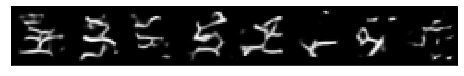

Epoch: 5 Iter: 605 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 5 Iter: 660 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 6 Iter: 715 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 6 Iter: 770 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 6 Iter: 825 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 7 Iter: 880 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 7 Iter: 935 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 8 Iter: 990 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 8 Iter: 1045 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 9 Iter: 1100 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 9 Iter: 1155 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 9 ======


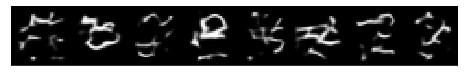

Epoch: 10 Iter: 1210 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 10 Iter: 1265 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 11 Iter: 1320 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 11 Iter: 1375 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 12 Iter: 1430 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 12 Iter: 1485 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 13 Iter: 1540 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 13 Iter: 1595 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 13 Iter: 1650 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 14 Iter: 1705 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 14 Iter: 1760 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 14 ======


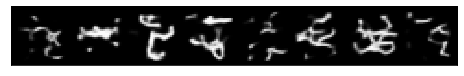

Epoch: 15 Iter: 1815 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 15 Iter: 1870 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 16 Iter: 1925 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 16 Iter: 1980 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 17 Iter: 2035 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 17 Iter: 2090 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 18 Iter: 2145 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 18 Iter: 2200 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 19 Iter: 2255 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 19 Iter: 2310 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 19 ======


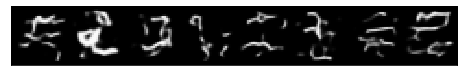

Epoch: 20 Iter: 2365 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 20 Iter: 2420 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 20 Iter: 2475 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 21 Iter: 2530 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 21 Iter: 2585 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 22 Iter: 2640 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 22 Iter: 2695 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 23 Iter: 2750 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 23 Iter: 2805 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 24 Iter: 2860 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 24 Iter: 2915 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 24 ======


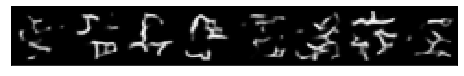

Epoch: 25 Iter: 2970 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 25 Iter: 3025 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 26 Iter: 3080 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 26 Iter: 3135 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 27 Iter: 3190 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 27 Iter: 3245 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 27 Iter: 3300 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 28 Iter: 3355 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 28 Iter: 3410 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 29 Iter: 3465 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 29 Iter: 3520 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 29 ======


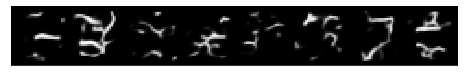

Epoch: 30 Iter: 3575 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 30 Iter: 3630 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 31 Iter: 3685 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 31 Iter: 3740 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 32 Iter: 3795 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 32 Iter: 3850 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 33 Iter: 3905 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 33 Iter: 3960 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 34 Iter: 4015 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 34 Iter: 4070 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 34 Iter: 4125 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 34 ======


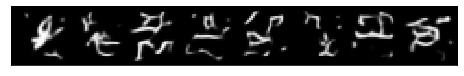

Epoch: 35 Iter: 4180 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 35 Iter: 4235 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 36 Iter: 4290 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 36 Iter: 4345 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 37 Iter: 4400 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 37 Iter: 4455 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 38 Iter: 4510 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 38 Iter: 4565 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 39 Iter: 4620 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 39 Iter: 4675 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 39 ======


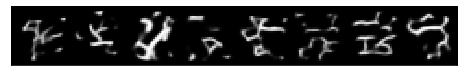

Epoch: 40 Iter: 4730 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 40 Iter: 4785 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 41 Iter: 4840 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 41 Iter: 4895 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 41 Iter: 4950 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 42 Iter: 5005 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 42 Iter: 5060 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 43 Iter: 5115 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 43 Iter: 5170 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 44 Iter: 5225 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 44 Iter: 5280 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 44 ======


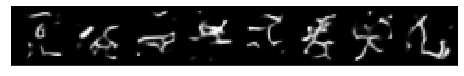

Epoch: 45 Iter: 5335 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 45 Iter: 5390 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 46 Iter: 5445 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 46 Iter: 5500 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 47 Iter: 5555 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 47 Iter: 5610 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 48 Iter: 5665 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 48 Iter: 5720 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 48 Iter: 5775 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 49 Iter: 5830 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 49 Iter: 5885 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 49 ======


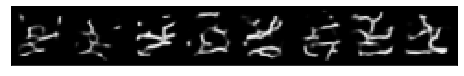

Epoch: 50 Iter: 5940 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 50 Iter: 5995 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 51 Iter: 6050 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 51 Iter: 6105 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 52 Iter: 6160 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 52 Iter: 6215 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 53 Iter: 6270 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 53 Iter: 6325 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 54 Iter: 6380 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 54 Iter: 6435 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 54 Iter: 6490 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 54 ======


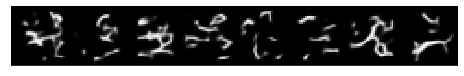

Epoch: 55 Iter: 6545 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 55 Iter: 6600 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 56 Iter: 6655 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 56 Iter: 6710 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 57 Iter: 6765 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 57 Iter: 6820 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 58 Iter: 6875 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 58 Iter: 6930 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 59 Iter: 6985 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 59 Iter: 7040 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 59 ======


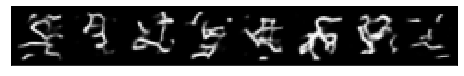

Epoch: 60 Iter: 7095 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 60 Iter: 7150 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 61 Iter: 7205 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 61 Iter: 7260 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 61 Iter: 7315 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 62 Iter: 7370 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 62 Iter: 7425 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 63 Iter: 7480 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 63 Iter: 7535 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 64 Iter: 7590 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 64 Iter: 7645 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 64 ======


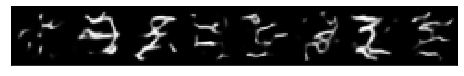

Epoch: 65 Iter: 7700 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 65 Iter: 7755 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 66 Iter: 7810 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 66 Iter: 7865 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 67 Iter: 7920 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 67 Iter: 7975 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 68 Iter: 8030 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 68 Iter: 8085 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 68 Iter: 8140 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 69 Iter: 8195 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 69 Iter: 8250 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 69 ======


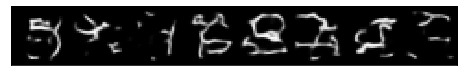

Epoch: 70 Iter: 8305 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 70 Iter: 8360 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 71 Iter: 8415 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 71 Iter: 8470 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 72 Iter: 8525 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 72 Iter: 8580 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 73 Iter: 8635 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 73 Iter: 8690 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 74 Iter: 8745 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 74 Iter: 8800 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 74 ======


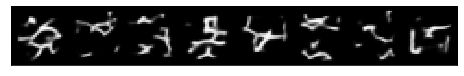

Epoch: 75 Iter: 8855 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 75 Iter: 8910 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 75 Iter: 8965 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 76 Iter: 9020 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 76 Iter: 9075 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 77 Iter: 9130 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 77 Iter: 9185 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 78 Iter: 9240 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 78 Iter: 9295 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 79 Iter: 9350 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 79 Iter: 9405 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 79 ======


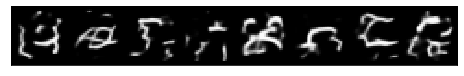

Epoch: 80 Iter: 9460 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 80 Iter: 9515 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 81 Iter: 9570 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 81 Iter: 9625 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 82 Iter: 9680 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 82 Iter: 9735 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 82 Iter: 9790 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 83 Iter: 9845 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 83 Iter: 9900 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 84 Iter: 9955 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 84 Iter: 10010 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 84 ======


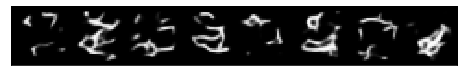

Epoch: 85 Iter: 10065 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 85 Iter: 10120 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 86 Iter: 10175 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 86 Iter: 10230 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 87 Iter: 10285 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 87 Iter: 10340 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 88 Iter: 10395 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 88 Iter: 10450 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 89 Iter: 10505 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 89 Iter: 10560 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 89 Iter: 10615 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
====== Epoch 89 ======


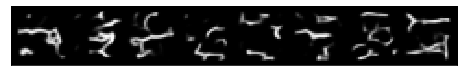

Epoch: 90 Iter: 10670 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 90 Iter: 10725 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 91 Iter: 10780 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 91 Iter: 10835 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 92 Iter: 10890 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0
Epoch: 92 Iter: 10945 GLoss: 100.0 DLoss: 50.0 Avg_D_real 0.0 Avg_D_fake 0.0


KeyboardInterrupt: 

In [14]:
print("Device in use: {}".format(CONFIG.DEVICE))

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, label in train_loader:
        x = x.to(CONFIG.DEVICE)
        
        with torch.no_grad():
            real = dvae.sm_encode(x)

        current_batch_dim = real.size(0)
        labels_real = torch.full((current_batch_dim,), 1.0, device=CONFIG.DEVICE)
        labels_fake = torch.full((current_batch_dim,), 0.0, device=CONFIG.DEVICE)

        D.zero_grad()
        G.zero_grad()
        
        ############################
        ### Update Discriminator ###
        ############################
        
        noise = torch.randn(current_batch_dim, CONFIG.noise_dim, 1, 1, device=CONFIG.DEVICE)
        fake = G(noise=noise)

        labels_D_real = D(real)
        d_loss_real = F.binary_cross_entropy(labels_D_real, labels_real)

        labels_D_fake = D(fake.detach())
        d_loss_fake = F.binary_cross_entropy(labels_D_fake, labels_fake)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        avg_label_D_real = labels_D_real.mean().item()
        avg_label_D_fake = labels_D_fake.mean().item()

        ############################
        ##### Update Generator #####
        ############################

        labels_D_fake = D(fake)

        g_loss = F.binary_cross_entropy(labels_D_fake, labels_real)
        g_loss.backward()
        optimizer_G.step()

        iteration += 1

        if iteration % 55 == 0:
            print("Epoch: {} Iter: {} GLoss: {} DLoss: {} Avg_D_real {} Avg_D_fake {}".format(
                epoch, 
                iteration, 
                round(g_loss.item(), 5), 
                round(d_loss.item(), 5), 
                round(avg_label_D_real, 5), 
                round(avg_label_D_fake, 5),
                #round(temp, 5)
            ))
    
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_img = dvae.q_decode(fake[:8, :, :, :], hard=True)
        img_grid = make_grid(fake_img.detach().cpu())
        print("====== Epoch {} ======".format(epoch))
        show(img_grid)
        print("======================")